In [64]:
import warnings
warnings.filterwarnings('ignore')
from pylab import rcParams
rcParams['figure.figsize'] = 10, 6
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
from pmdarima.arima import auto_arima
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math
import numpy as np
from nsepy import get_history
from datetime import date
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import datetime

In [65]:
import yfinance as yf

# Get the data for the stock AAPL
data = yf.download('AAPL','2016-01-01','2019-08-01')
data

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2015-12-31,26.752501,26.757500,26.205000,26.315001,24.302439,163649200
2016-01-04,25.652500,26.342501,25.500000,26.337500,24.323219,270597600
2016-01-05,26.437500,26.462500,25.602501,25.677500,23.713696,223164000
2016-01-06,25.139999,25.592501,24.967501,25.174999,23.249626,273829600
2016-01-07,24.670000,25.032499,24.107500,24.112499,22.268383,324377600
...,...,...,...,...,...,...
2019-07-25,52.222500,52.310001,51.682499,51.755001,50.802307,55638400
2019-07-26,51.869999,52.432499,51.785000,51.935001,50.978992,70475600
2019-07-29,52.115002,52.660000,52.110001,52.419998,51.455059,86693600


In [66]:
df=pd.DataFrame(data['Adj Close'],index=data.index)
df=df.rename(columns={"Adj Close":"close"})

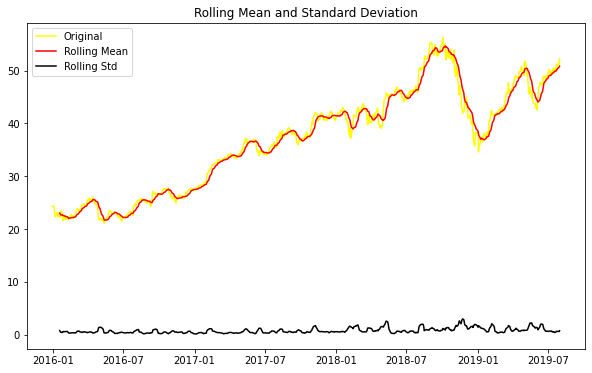

Results of dickey fuller test
Test Statistics                 -0.966102
p-value                          0.765426
No. of lags used                 8.000000
Number of observations used    892.000000
critical value (1%)             -3.437702
critical value (5%)             -2.864786
critical value (10%)            -2.568498
dtype: float64


In [67]:
def test_stationarity(timeseries):
    #Determing rolling statistics
    rolmean = timeseries.rolling(12).mean()
    rolstd = timeseries.rolling(12).std()
    #Plot rolling statistics:
    plt.plot(timeseries, color='yellow',label='Original')
    plt.plot(rolmean, color='red', label='Rolling Mean')
    plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean and Standard Deviation')
    plt.show(block=False)
    print("Results of dickey fuller test")
    adft = adfuller(timeseries,autolag='AIC')
    # output for dft will give us without defining what the values are.
    #hence we manually write what values does it explains using a for loop
    output = pd.Series(adft[0:4],index=['Test Statistics','p-value','No. of lags used','Number of observations used'])
    for key,values in adft[4].items():
        output['critical value (%s)'%key] =  values
    print(output)

test_stationarity(df['close'])

<Figure size 720x432 with 0 Axes>

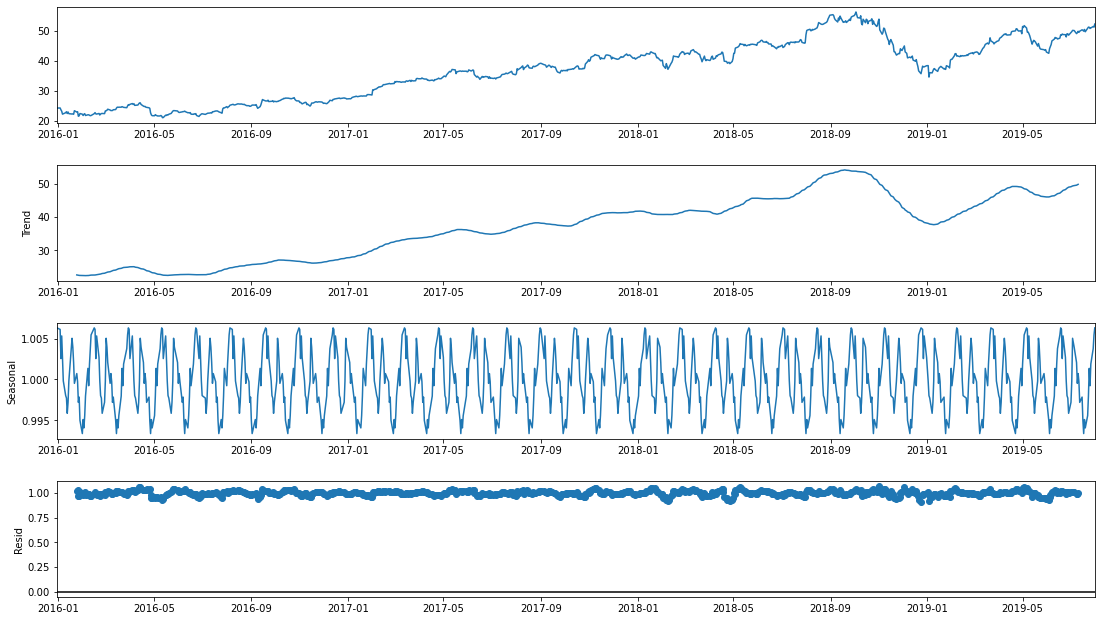

In [68]:
result = seasonal_decompose(df, model='multiplicative', freq = 30)
fig = plt.figure()  
fig = result.plot()  
fig.set_size_inches(16, 9)

No handles with labels found to put in legend.


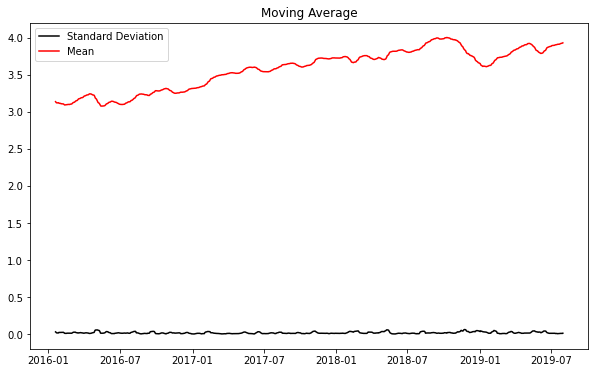

In [69]:
from pylab import rcParams
rcParams['figure.figsize'] = 10, 6
df_log = np.log(df['close'])
moving_avg = df_log.rolling(12).mean()
std_dev = df_log.rolling(12).std()
plt.legend(loc='best')
plt.title('Moving Average')
plt.plot(std_dev, color ="black", label = "Standard Deviation")
plt.plot(moving_avg, color="red", label = "Mean")
plt.legend()
plt.show()

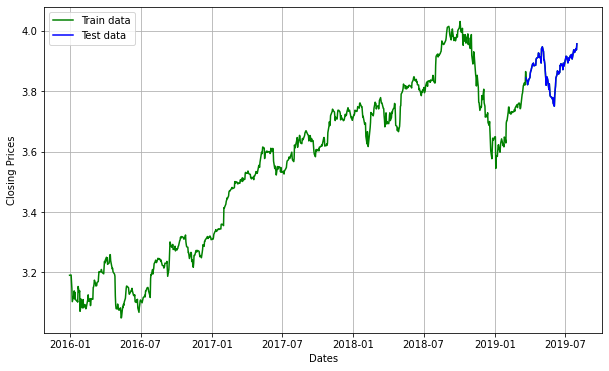

In [70]:
train_data, test_data = df_log[3:int(len(df_log)*0.9)], df_log[int(len(df_log)*0.9):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.xlabel('Dates')
plt.ylabel('Closing Prices')
plt.plot(df_log, 'green', label='Train data')
plt.plot(test_data, 'blue', label='Test data')
plt.legend()

In [71]:
model_autoARIMA = auto_arima(train_data, start_p=0, start_q=0,
    test='adf',       # use adftest to find optimal 'd'
    max_p=10, max_q=10, # maximum p and q
    m=2,              # frequency of series
    d=None,           # let model determine 'd'
    seasonal=False,   # No Seasonality
    start_P=0, 
    max_P=3,
    start_Q=0,
    max_Q=3,
    D=0, 
    trace=True,
    error_action='ignore',  
    suppress_warnings=True, 
    stepwise=True)
print(model_autoARIMA.summary())

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-4432.213, Time=0.18 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-4430.547, Time=0.10 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-4430.578, Time=0.21 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-4431.531, Time=0.10 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-4428.578, Time=0.52 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0] intercept
Total fit time: 1.126 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  807
Model:               SARIMAX(0, 1, 0)   Log Likelihood                2218.107
Date:                Fri, 23 Jul 2021   AIC                          -4432.213
Time:                        12:35:34   BIC                          -4422.829
Sample:                             0   HQIC                         -4428.610
                                - 807                                  

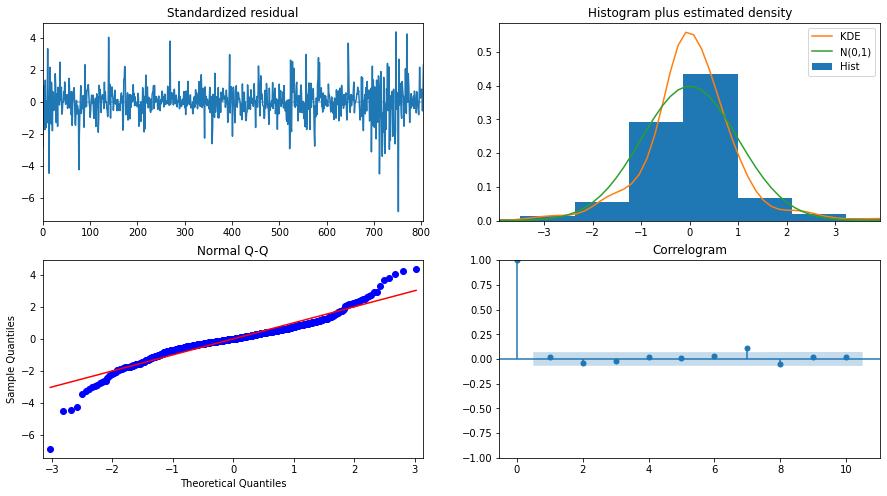

In [72]:
model_autoARIMA.plot_diagnostics(figsize=(15,8))
plt.show()

In [73]:
model = ARIMA(train_data, order=(3, 1, 2))
fitted = model.fit(disp=-1)
print(fitted.summary())

                             ARIMA Model Results                              
Dep. Variable:                D.close   No. Observations:                  806
Model:                 ARIMA(3, 1, 2)   Log Likelihood                2221.781
Method:                       css-mle   S.D. of innovations              0.015
Date:                Fri, 23 Jul 2021   AIC                          -4429.562
Time:                        12:35:45   BIC                          -4396.718
Sample:                             1   HQIC                         -4416.949
                                                                              
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0009      0.001      1.625      0.104      -0.000       0.002
ar.L1.D.close     1.2460      0.039     32.080      0.000       1.170       1.322
ar.L2.D.close    -1.0201      0.044    -

In [74]:
fc, se, conf = fitted.forecast(91, alpha=0.05)  # 95% confidence

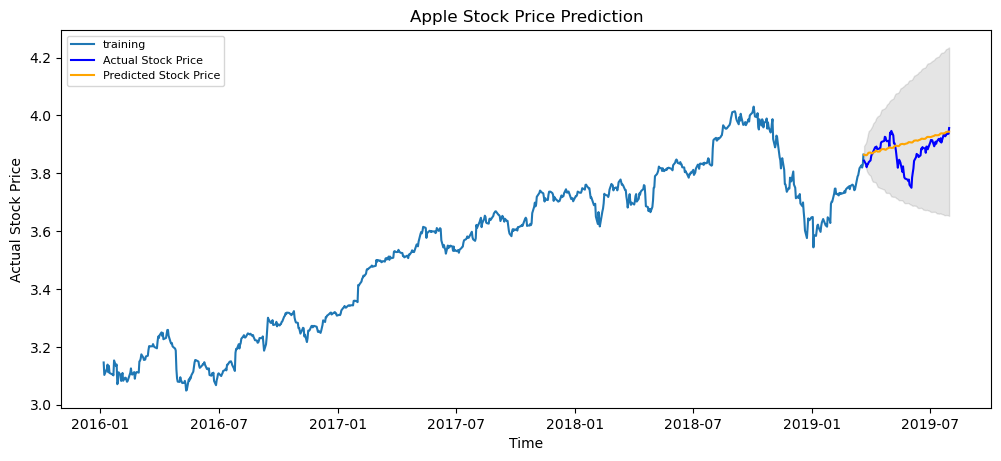

In [75]:
fc_series = pd.Series(fc, index=test_data.index)
lower_series = pd.Series(conf[:, 0], index=test_data.index)
upper_series = pd.Series(conf[:, 1], index=test_data.index)
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, color = 'blue', label='Actual Stock Price')
plt.plot(fc_series, color = 'orange',label='Predicted Stock Price')
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.10)
plt.title('Apple Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Actual Stock Price')
plt.legend(loc='upper left', fontsize=8)
plt.show()

In [80]:
from dateutil.relativedelta import relativedelta
date_list = [datetime.datetime.strptime("2019-08-01", "%Y-%m-%d") + 
             relativedelta(days=x) for x in range(0,50)]


In [81]:
future = pd.DataFrame(index=date_list, columns= df.columns)
df2 = pd.concat([df, future])

In [82]:
df.shape

(901, 1)

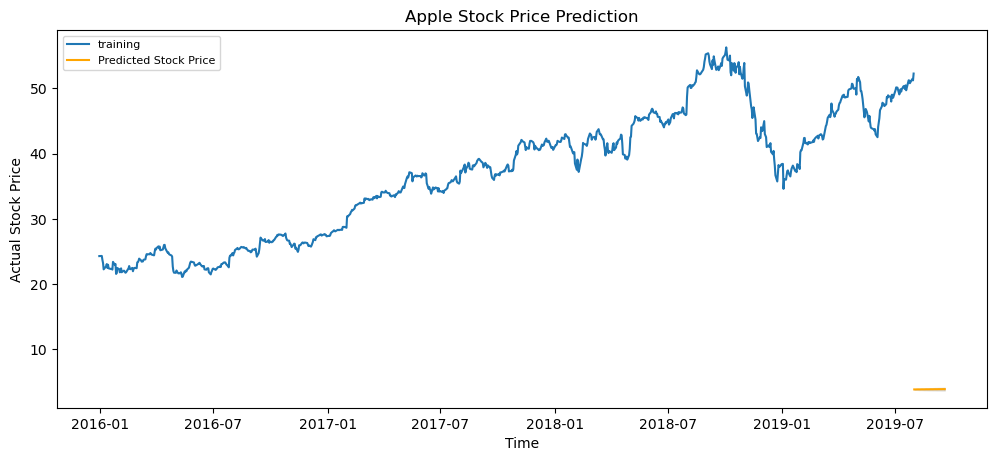

In [83]:
fc, se, conf = fitted.forecast(50, alpha=0.05)  # 95% confidence

fc_series = pd.Series(fc, index=future.index)
lower_series = pd.Series(conf[:, 0], index=future.index)
upper_series = pd.Series(conf[:, 1], index=future.index)
plt.figure(figsize=(12,5), dpi=100)
plt.plot(df, label='training')
#plt.plot(future, color = 'blue', label='Actual Stock Price')
plt.plot(fc_series, color = 'orange',label='Predicted Stock Price')
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.10)
plt.title('Apple Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Actual Stock Price')
plt.legend(loc='upper left', fontsize=8)
plt.show()

In [85]:
model_autoARIMA = auto_arima(df, start_p=0, start_q=0,
    test='adf',       # use adftest to find optimal 'd'
    max_p=10, max_q=10, # maximum p and q
    m=2,              # frequency of series
    d=None,           # let model determine 'd'
    seasonal=False,   # No Seasonality
    start_P=0, 
    max_P=3,
    start_Q=0,
    max_Q=3,
    D=0, 
    trace=True,
    error_action='ignore',  
    suppress_warnings=True, 
    stepwise=True)
print(model_autoARIMA.summary())

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1636.589, Time=0.11 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1638.434, Time=0.07 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=1638.422, Time=0.12 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1637.007, Time=0.03 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=1638.014, Time=0.36 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0] intercept
Total fit time: 0.694 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  901
Model:               SARIMAX(0, 1, 0)   Log Likelihood                -816.294
Date:                Fri, 23 Jul 2021   AIC                           1636.589
Time:                        12:47:06   BIC                           1646.194
Sample:                             0   HQIC                          1640.258
                                - 901                                       

In [95]:
model = ARIMA(df, order=(3, 1, 2))
fitted = model.fit(disp=1)
print(fitted.summary())

                             ARIMA Model Results                              
Dep. Variable:                D.close   No. Observations:                  900
Model:                 ARIMA(3, 1, 2)   Log Likelihood                -809.072
Method:                       css-mle   S.D. of innovations              0.593
Date:                Fri, 23 Jul 2021   AIC                           1632.144
Time:                        12:50:17   BIC                           1665.761
Sample:                             1   HQIC                          1644.986
                                                                              
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0311      0.020      1.582      0.114      -0.007       0.070
ar.L1.D.close     1.6665      0.033     49.842      0.000       1.601       1.732
ar.L2.D.close    -1.0178      0.055    -

In [96]:
fc, se, conf = fitted.forecast(50, alpha=0.05)  # 95% confidence

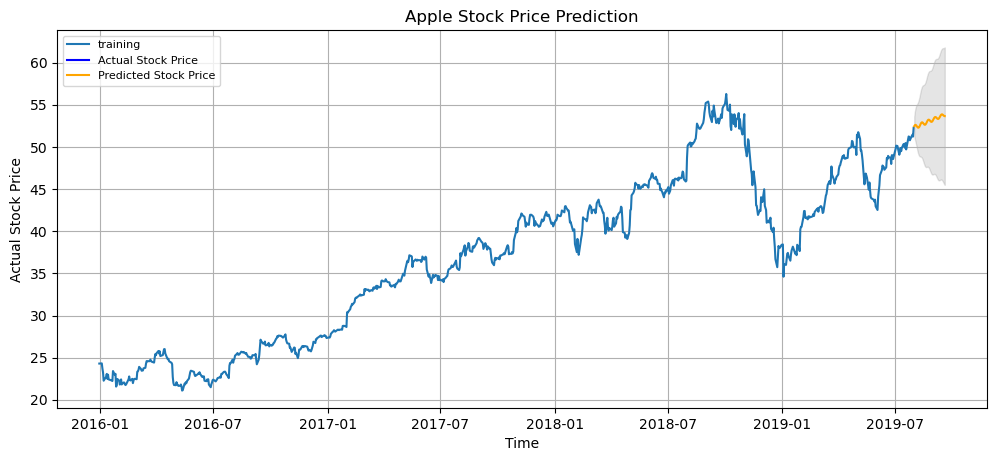

In [98]:
fc_series = pd.Series(fc, index=future.index)
lower_series = pd.Series(conf[:, 0], index=future.index)
upper_series = pd.Series(conf[:, 1], index=future.index)
plt.figure(figsize=(12,5), dpi=100)
plt.grid(True)
plt.plot(df, label='training')
plt.plot(future, color = 'blue', label='Actual Stock Price')
plt.plot(fc_series, color = 'orange',label='Predicted Stock Price')
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.10)
plt.title('Apple Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Actual Stock Price')
plt.legend(loc='upper left', fontsize=8)
plt.show()